****
# Time Synchronizer use example
****

In [39]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from utils.build_raw_inputs import find_et_tsv
from sync.synchronizer import TimeSynchronizer

base_et_dir = Path("/store/kruu/eye_tracking/training_data")
tsv_files = list(
    base_et_dir.glob("*/Scenario */ET/*_scenario_*_gaze_data_fusion.tsv")
)


In [42]:
sync_base = Path("/store/regd/sync_points")

drift_means = [] 

for tsv_path in tsv_files:
    
    tsv_path = Path(tsv_path)
    participant_id = tsv_path.parts[-4]         
    scenario = tsv_path.parts[-3].split()[-1]  
    json_path = sync_base / f"{participant_id}_scenario_{scenario}_sync_points.json"
    
    if not json_path.exists():
        print(f"No time sync for participant {participant_id} Scenario {scenario}")
        continue
    
    df_et = pd.read_csv(tsv_path,sep='\t')
    with open(json_path, 'r') as f:
        sync_data: dict = json.load(f)
    
    syncer = TimeSynchronizer(json_path)
    synced_ms = syncer(df_et, timezone="Europe/Zagreb")
    df_et["epoch_ms_synced"] = synced_ms.astype("int64")
    
    raw_ts = (
        df_et["Recording timestamp [ms]"].to_numpy()
        + (df_et["epoch_ms_synced"].iloc[0] - df_et["Recording timestamp [ms]"].iloc[0])
    )
    drift = raw_ts - df_et["epoch_ms_synced"].to_numpy()
    
    drift_means.append(np.nanmean(drift))

/tmp/ipykernel_2754560/2814904034.py:16: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_et = pd.read_csv(tsv_path,sep='\t')
2026-01-12 15:12:43,538 DEBUG Sync Coverage Breakdown: Left Extrap=2,188 (0.5%) | Inside=447,090 (99.0%) | Right Extrap=2,355 (0.5%)
/tmp/ipykernel_2754560/2814904034.py:16: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_et = pd.read_csv(tsv_path,sep='\t')
2026-01-12 15:12:45,306 DEBUG Sync Coverage Breakdown: Left Extrap=21,071 (4.5%) | Inside=439,922 (94.6%) | Right Extrap=3,811 (0.8%)
/tmp/ipykernel_2754560/2814904034.py:16: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_et = pd.read_csv(tsv_path,sep='\t')
2026-01-12 15:12:47,063 DEBUG Sync Coverage Breakdown: Left Extrap=18,105 (4.0%) | Inside=432,568 (95.4%) | Right Extrap=2,914 (0.6%)


No time sync for participant 002 Scenario 1


/tmp/ipykernel_2754560/2814904034.py:16: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_et = pd.read_csv(tsv_path,sep='\t')
2026-01-12 15:12:48,849 DEBUG Sync Coverage Breakdown: Left Extrap=15,742 (3.4%) | Inside=440,481 (95.3%) | Right Extrap=5,848 (1.3%)
/tmp/ipykernel_2754560/2814904034.py:16: DtypeWarning: Columns (7,8,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_et = pd.read_csv(tsv_path,sep='\t')
2026-01-12 15:12:50,677 DEBUG Sync Coverage Breakdown: Left Extrap=20,274 (4.3%) | Inside=447,816 (94.2%) | Right Extrap=7,345 (1.5%)
/tmp/ipykernel_2754560/2814904034.py:16: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_et = pd.read_csv(tsv_path,sep='\t')
2026-01-12 15:12:52,322 DEBUG Sync Coverage Breakdown: Left Extrap=4,696 (1.1%) | Inside=432,278 (98.6%) | Right Extrap=1,503 (0.3%)
/tm

In [47]:
np.max(drift_means), np.min(drift_means), np.std(drift_means)

(np.float64(748.8622254664119),
 np.float64(-2793.954033344451),
 np.float64(483.82369778530807))

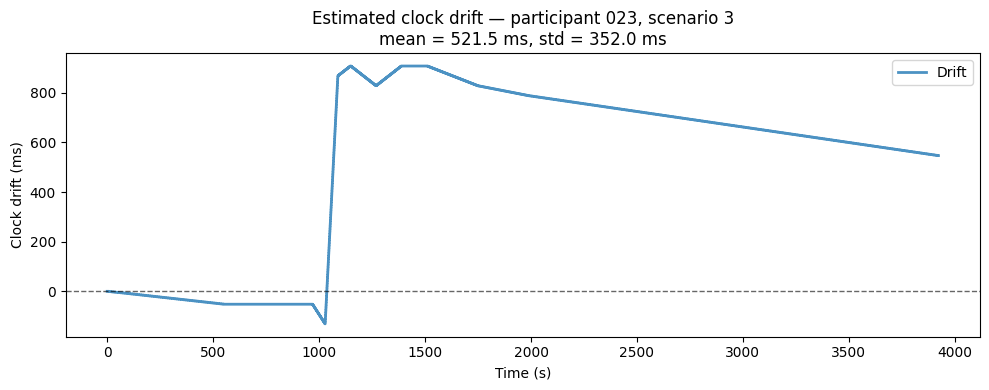

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Monotonicity
assert (np.diff(df_et["epoch_ms_synced"]) >= 0).all()

raw_ts = (
    df_et["Recording timestamp [ms]"].to_numpy()
    + (df_et["epoch_ms_synced"].iloc[0] - df_et["Recording timestamp [ms]"].iloc[0])
)

fs = 120.0
drift = raw_ts - df_et["epoch_ms_synced"].to_numpy()
t_s = np.arange(len(drift)) / fs

plt.figure(figsize=(10, 4))

plt.plot(t_s, drift, alpha=0.8, linewidth=2, label="Drift")

plt.axhline(0, linestyle="--", linewidth=1, color="black", alpha=0.6)

plt.xlabel("Time (s)")
plt.ylabel("Clock drift (ms)")
plt.title(
    "Estimated clock drift — participant 023, scenario 3\n"
    f"mean = {np.nanmean(drift):.1f} ms, std = {np.nanstd(drift):.1f} ms"
)

plt.legend()
plt.tight_layout()
plt.show()

****
# Comparison before/after Time Syncrhonizer
****

In [5]:
import os
import pandas as pd
from utils.helper import load_and_process_et, load_asd_scenario_data, drop_chunks_with_nan_et

In [9]:
path_before_time_sync = "/store/kruu/eye_tracking/training_data_after_review_no_time_sync/001/Scenario 1/taskRecognition/raw_et.parquet"
path_after_time_sync = "/store/kruu/eye_tracking/training_data/001/Scenario 1/taskRecognition/raw_et.parquet"

raw_no_time_sync = pd.read_parquet(path_before_time_sync)
raw_time_sync = pd.read_parquet(path_after_time_sync)

In [10]:
raw_no_time_sync

,Participant name,epoch_ms,Recording date,Recording timestamp [ms],Event,Gaze point X [DACS px],Gaze point Y [DACS px]
0,1,1758697911730,24.09.2025,6544,None,812.0,527.0
1,1,1758697911736,24.09.2025,6550,None,NaN,NaN
2,1,1758697911738,24.09.2025,6552,None,810.0,526.0
3,1,1758697911747,24.09.2025,6561,None,811.0,530.0
4,1,1758697911749,24.09.2025,6563,None,NaN,NaN
...,...,...,...,...,...,...,...
450482,1,1758701657467,24.09.2025,3752281,None,NaN,NaN
450483,1,1758701657471,24.09.2025,3752285,None,NaN,NaN
450484,1,1758701657479,24.09.2025,3752293,None,NaN,NaN
450485,1,1758701657480,24.09.2025,3752294,None,NaN,NaN


In [11]:
raw_time_sync

,Participant name,epoch_ms,epoch_ms_raw,epoch_ms_synced,Recording date,Recording timestamp [ms],Event,Gaze point X [DACS px],Gaze point Y [DACS px]
0,1,1758697849128,1758697911730,1758697849128,24.09.2025,6544,None,812.0,527.0
1,1,1758697849134,1758697911736,1758697849134,24.09.2025,6550,None,NaN,NaN
2,1,1758697849136,1758697911738,1758697849136,24.09.2025,6552,None,810.0,526.0
3,1,1758697849145,1758697911747,1758697849145,24.09.2025,6561,None,811.0,530.0
4,1,1758697849147,1758697911749,1758697849147,24.09.2025,6563,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...
450482,1,1758701594389,1758701657467,1758701594389,24.09.2025,3752281,None,NaN,NaN
450483,1,1758701594393,1758701657471,1758701594393,24.09.2025,3752285,None,NaN,NaN
450484,1,1758701594401,1758701657479,1758701594401,24.09.2025,3752293,None,NaN,NaN
450485,1,1758701594402,1758701657480,1758701594402,24.09.2025,3752294,None,NaN,NaN


In [12]:
store_dir = "/store/kruu/eye_tracking"
data_dir_sync = os.path.join(store_dir, "training_data")
data_dir_not_sync = os.path.join(store_dir, "training_data_after_review_no_time_sync")

features = ['Recording timestamp [ms]', 'epoch_ms', 'Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Event']
interpolate_cols = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]']
fill_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]']
columns_to_extract = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]'] # Columns for TSFresh
    
# ------------------------- 1. LOADING DATASET -------------------------

chunks_et_sync, blinks_sync, atco_task_map_sync = load_and_process_et(root_dir = data_dir_sync,
                                                        columns = features,
                                                        interpolate_cols = interpolate_cols,
                                                        fill_cols = fill_columns,
                                                        window_short_ms = 5000,
                                                        window_mid_ms = 10000,
                                                        window_long_ms = 25000,
                                                        task_margin_ms = 2000,
                                                        step_ms = 3000,
                                                        filter_outliers = True,
                                                        participants=["001", "002", "003", "004", "005"],
                                                        time_resampling=False)

chunks_et_not_sync, blinks_not_sync, atco_task_map_not_sync = load_and_process_et(root_dir = data_dir_not_sync,
                                                        columns = features,
                                                        interpolate_cols = interpolate_cols,
                                                        fill_cols = fill_columns,
                                                        window_short_ms = 5000,
                                                        window_mid_ms = 10000,
                                                        window_long_ms = 25000,
                                                        task_margin_ms = 2000,
                                                        step_ms = 3000,
                                                        filter_outliers = True,
                                                        participants=["001", "002", "003", "004", "005"],
                                                        time_resampling=False)

⚠️ Unmatched 'end' for Task 5 at 824448
⚠️ Unmatched 'start' for Task 4 at 3513371
Finding tasks for participant 001 Scenario 1
Finding tasks for participant 001 Scenario 2
Finding tasks for participant 001 Scenario 3
Finding tasks for participant 002 Scenario 1
⚠️ Unmatched 'end' for Task 5 at 824448
Finding tasks for participant 002 Scenario 2
⚠️ Unmatched 'start' for Task 4 at 3513371
Finding tasks for participant 002 Scenario 3
Finding tasks for participant 003 Scenario 1
Finding tasks for participant 003 Scenario 3
Finding tasks for participant 004 Scenario 1
Finding tasks for participant 004 Scenario 2
Finding tasks for participant 004 Scenario 3
Finding tasks for participant 005 Scenario 1
Finding tasks for participant 005 Scenario 2
Finding tasks for participant 005 Scenario 3
⚠️ Unmatched 'end' for Task 5 at 824448
⚠️ Unmatched 'start' for Task 4 at 3513371
Finding tasks for participant 001 Scenario 1
Finding tasks for participant 001 Scenario 2
Finding tasks for participant 0

In [22]:
idx = '001_1_10_0'
window_len = ['short', 'mid', 'long']

chunks_et_sync[idx][window_len[0]]

,Recording timestamp [ms],epoch_ms,Gaze point X [DACS px],Gaze point Y [DACS px],Event,Blink,Loss of Attention,Task_id,Task_execution,Participant name,Scenario_id,id,anchor_time,label_time
285355,2378546,1758700220479,829.0,427.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285356,2378554,1758700220487,822.0,418.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285357,2378562,1758700220495,811.0,415.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285358,2378571,1758700220504,819.0,419.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285359,2378579,1758700220512,819.0,409.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285951,2383504,1758700225438,833.0,413.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285952,2383512,1758700225446,835.0,404.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285953,2383521,1758700225455,838.0,414.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285954,2383529,1758700225463,836.0,413.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0


In [23]:
chunks_et_not_sync[idx][window_len[0]]

,Recording timestamp [ms],epoch_ms,Gaze point X [DACS px],Gaze point Y [DACS px],Event,Blink,Loss of Attention,Task_id,Task_execution,Participant name,Scenario_id,id,anchor_time,label_time
285355,2378546,1758700283732,829.0,427.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285356,2378554,1758700283740,822.0,418.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285357,2378562,1758700283748,811.0,415.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285358,2378571,1758700283757,819.0,419.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285359,2378579,1758700283765,819.0,409.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285951,2383504,1758700288690,833.0,413.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285952,2383512,1758700288698,835.0,404.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285953,2383521,1758700288707,838.0,414.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0
285954,2383529,1758700288715,836.0,413.0,None,False,False,10,0,001,1,001_1_10_0,2383544.0,2383544.0


The ASD time synching doesn't change a lot the eye tracking chunks htemselves as it only modifies the epoch_ms column. However, it changes th ASD events that are associated with them.

In [36]:
asd_scenarios = load_asd_scenario_data(root_dir=data_dir_sync)
prepared_asd = {}
for key, df_sc in asd_scenarios.items():
    asd = df_sc.sort_values("epoch_ms").set_index("epoch_ms")
    prepared_asd[key] = asd

p_s_id = "_".join(idx.split("_")[:2])
scenario_asd = prepared_asd.get(p_s_id)

window_asd_sync = scenario_asd.loc[chunks_et_sync[idx][window_len[0]]["epoch_ms"].min():chunks_et_sync[idx][window_len[0]]["epoch_ms"].max()].reset_index()
window_asd_not_sync = scenario_asd.loc[chunks_et_not_sync[idx][window_len[0]]["epoch_ms"].min():chunks_et_not_sync[idx][window_len[0]]["epoch_ms"].max()].reset_index()

In [39]:
from utils.data_processing_asd_events import ASDEventsMetricsProcessor

asd_processor_sync = ASDEventsMetricsProcessor(window_asd_sync)
asd_metrics_sync = asd_processor_sync.compute_all_metrics()   

asd_processor_not_sync = ASDEventsMetricsProcessor(window_asd_not_sync)
asd_metrics_not_sync = asd_processor_not_sync.compute_all_metrics() 

In [40]:
asd_metrics_sync

,n_events_total,n_events_unique,events_per_ms,events_per_timestamp,event_type_entropy,event_mouse_position_count,event_track_screen_position_count,event_track_label_position_count,event_popup_count,event_transfer_count,...,clearance_type_direct-to_present,clearance_type_heading_count,clearance_type_heading_present,clearance_type_route-clearance_count,clearance_type_route-clearance_present,clearance_inter_event_mean_ms,clearance_inter_event_median_ms,clearance_inter_event_std_ms,clearance_max_per_flight,clearance_mean_per_flight
0,61,3,0.030653,4.066667,1.057318,13,21,27,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0,0.0


In [41]:
asd_metrics_not_sync

,n_events_total,n_events_unique,events_per_ms,events_per_timestamp,event_type_entropy,event_mouse_position_count,event_track_screen_position_count,event_track_label_position_count,event_popup_count,event_transfer_count,...,clearance_type_direct-to_present,clearance_type_heading_count,clearance_type_heading_present,clearance_type_route-clearance_count,clearance_type_route-clearance_present,clearance_inter_event_mean_ms,clearance_inter_event_median_ms,clearance_inter_event_std_ms,clearance_max_per_flight,clearance_mean_per_flight
0,96,4,0.021178,2.594595,1.125207,35,23,37,0,1,...,0,0,0,0,0,0.0,0.0,0.0,0,0.0
